In [1]:
from cortexlib.utils.plotting import simclr_colours, vgg19_colours
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import to_rgb
from pathlib import Path
import pandas as pd
import numpy as np
import json


paths = [
    Path("../../../analysis/mouse_m01_d2/03_simclr_neural/explained_variance.json"),
    Path("../../../analysis/mouse_m01_d2/05_vgg19_neural/explained_variance.json"),
    Path("../../../analysis/mouse_m02_d3/03_simclr_neural/explained_variance.json"),
    Path("../../../analysis/mouse_m02_d3/05_vgg19_neural/explained_variance.json"),
    Path("../../../analysis/mouse_m03_d4/03_simclr_neural/explained_variance.json"),
    Path("../../../analysis/mouse_m03_d4/05_vgg19_neural/explained_variance.json"),
]

all_data = []
for path in paths:
    with open(path, "r") as f:
        data = json.load(f)
        all_data.extend(data)

records = []

for entry in all_data:
    mouse_id = entry['mouse_id']
    model = entry['model'].lower()
    layer = entry['layer']
    subsampled_dims = entry['subsampled_dimensions']
    
    pcs_90 = [s['num_principal_components_90pc_ev'] for s in entry['subsamples']]
    mean_pc_90 = np.mean(pcs_90)
    percent_pc_90 = (mean_pc_90 / subsampled_dims) * 100
    
    records.append({
        'mouse_id': mouse_id,
        'model': model,
        'layer': layer,
        'pc_percent_90': percent_pc_90
    })

ev_df = pd.DataFrame(records)
ev_df.head(50)

,mouse_id,model,layer,pc_percent_90
0,m01_d2,simclr,layer1,57.226562
1,m01_d2,simclr,layer2,46.289062
2,m01_d2,simclr,layer3,36.328125
3,m01_d2,simclr,layer4,35.742188
4,m01_d2,simclr,fc,22.851562
5,m01_d2,vgg19,conv2_2,2.343750
6,m01_d2,vgg19,conv3_4,3.906250
7,m01_d2,vgg19,conv4_4,7.031250
8,m01_d2,vgg19,conv5_4,3.906250
9,m01_d2,vgg19,fc2,10.156250


In [2]:
summary = (
    ev_df.groupby(['model', 'layer'])
      .agg(mean=('pc_percent_90', 'mean'),
           sem=('pc_percent_90', lambda x: x.std(ddof=1) / np.sqrt(len(x))))
      .reset_index()
)
summary.head(20)

,model,layer,mean,sem
0,simclr,fc,23.111979,0.130208
1,simclr,layer1,58.072917,0.426917
2,simclr,layer2,46.809896,0.260417
3,simclr,layer3,36.653646,0.172249
4,simclr,layer4,36.132812,0.195312
5,vgg19,conv2_2,2.343750,0.000000
6,vgg19,conv3_4,3.906250,0.000000
7,vgg19,conv4_4,7.031250,0.000000
8,vgg19,conv5_4,3.906250,0.000000
9,vgg19,fc2,10.156250,0.000000


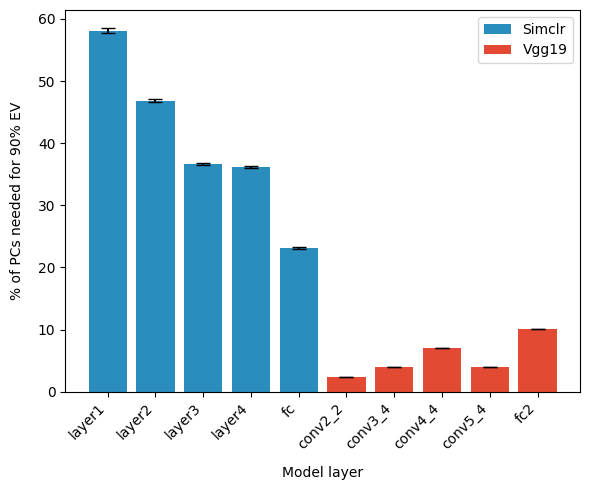

In [3]:
layer_order = [
    'layer1', 'layer2', 'layer3', 'layer4', 'fc',
    'conv2_2', 'conv3_4', 'conv4_4', 'conv5_4', 'fc2'
]
summary['layer'] = pd.Categorical(summary['layer'], categories=layer_order, ordered=True)
summary = summary.sort_values('layer')

model_colour = {
    'simclr': simclr_colours['layer4'],
    'vgg19': vgg19_colours['conv5_4'],
}
summary['color'] = summary['model'].map(model_colour)

x_labels = summary['layer'].astype(str)
heights = summary['mean']
errors = summary['sem']
colors = summary['color']

plt.figure(figsize=(6, 5))
plt.bar(
    x=x_labels,
    height=heights,
    yerr=errors,
    capsize=5,
    color=colors
)

plt.ylabel('% of PCs needed for 90% EV', labelpad=10)
plt.xlabel('Model layer', labelpad=10)
plt.xticks(rotation=45, ha='right')

plt.legend(
    handles=[
        Patch(facecolor=color, label=label.capitalize())
        for label, color in model_colour.items()
    ]
)

plt.tight_layout()
plt.savefig("./figures/explained-variance-bar.svg", format='svg')
plt.show()